## Getting Frequency Distribution of Paths

For all pairs. All the Paths and the paths which were taken more than once.


In [1]:
import certifi
from elasticsearch import Elasticsearch

import r_utils as ut

import time
import csv 
import pandas as pd
import numpy as np
from collections import Counter
import multiprocessing as mp


In [2]:
with open("../creds.key") as f:
    usrname = f.readline().strip()
    passwd = f.readline().strip()

# Connecting to Kibana
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=120, http_auth=(usrname, passwd), scheme= 'ssl')


In [3]:
def getSourceDestinationPairs(to_date, from_date):
    """
    Get all source and destination pairs
    present in the given time range 
    
    Args:
        to_date:  epoch_millis
        from_date: epoch_millis
    
    Returns:
        Datafame of all source destination pairs
    """
    
    query = {
        "size":0,
        "query":{
            "bool":{
                "must":[
                    {
                        "range":{
                            "timestamp":{
                                "gte":from_date,
                                "lte":to_date,
                                "format":"epoch_millis"
                            }
                        }
                    },
                    {
                        "term":{
                            "dest_production":{
                                "value":"true"
                            }
                        }
                    },
                    {
                        "term":{
                            "src_production":{
                                "value":"true"
                            }
                        }
                    }
                ]
            }
        },
        "aggs":{
            "sources":{
                "terms":{
                    "field":"src",
                    "size":9999
                },
                "aggs":{
                    "destinations":{
                        "terms":{
                            "field":"dest",
                            "size":9999
                        }
                    }
                }
            }
        }
    }

    data = es.search('ps_trace', body=query)
    
    sources = []
    destinations = []

    for source in data['aggregations']['sources']['buckets']:
        src = source['key']
        for destination in source['destinations']['buckets']:
            sources.append(src)
            destinations.append(destination['key'])
    
    return pd.DataFrame({"Source":sources,
                        "Destinations":destinations})

def getPathCounts(src_ip, dest_ip):
    """
    Returns a list of Counts of Paths taken from given source and destination

    Args:
        src_ip: Source IP, String [ex: "192.168.1.1"]
        dest_ip: Destination IP, String [ex: "192.168.1.5"]
    
    Returns:
        A list of dictionaries. The dictionary looks as follows:
        {
            'key':HASH VALUE,
            'doc_count': # of times path taken
        }
    """
    to_date = ut.getDateFormat()
    from_date = ut.getDateFormat(delta=90)

    query = {
        "size":0,
        "query":{
            "bool":{
                "must":[
                    {
                        "range":{
                            "timestamp":{
                                "gte":from_date,
                                "lte":to_date,
                                "format":"epoch_millis"
                            }
                        }
                    },
                    {
                        "term":{
                            "src":{
                                "value":src_ip
                            }
                        }
                    },
                    {
                        "term":{
                            "dest":{
                                "value":dest_ip
                            }
                        }
                    },
                    {
                        "term":{
                            "src_production":{
                                "value":"true"
                            }
                        }
                    },
                    {
                        "term":{
                            "dest_production":{
                                "value":"true"
                            }
                        }
                    }
                ]
            }
        },
        "aggs":{
            "HashCounts":{
                "terms":{
                    "field":"hash",
                    "size":4999
                }
            }
        }
    }

    try:
        data = es.search('ps_trace', body=query)
    except Exception as e:
        print(e, src_ip, dest_ip)
        return -1
    paths = data["aggregations"]["HashCounts"]["buckets"]
    
    if len(paths) == 0:
        return -1 
    else:
        return paths

def topk(src_ip, dest_ip,k=1):
    """
    Returns a  tuple of total paths and paths taken more than k times

    Args:
        src_ip: Source IP, String [ex: "192.168.1.1"]
        dest_ip: Destination IP, String [ex: "192.168.1.5"]


    Returns:
        A tuple of total unique paths and total of paths taken more than k times
        If there are no paths between soure and destination, None is returned
    """
    paths = getPathCounts(src_ip, dest_ip)

    if paths == -1:
        return None

    totalPaths = 0
    moreKPaths = 0

    totalPaths = len(paths)

    for item in paths:
        if item['doc_count'] > k:
            moreKPaths += 1
    
    return (totalPaths, moreKPaths)


In [4]:

src_dest_pairs = getSourceDestinationPairs(ut.getDateFormat(), ut.getDateFormat(delta=90))
src_dest_pairs['Total'] = np.zeros(src_dest_pairs.shape[0])
src_dest_pairs['MoreThanOne'] = np.zeros(src_dest_pairs.shape[0])
src_dest_pairs['Processed'] = np.zeros(src_dest_pairs.shape[0])
src_dest_pairs.head()



,Source,Destinations,Total,MoreThanOne,Processed
0,202.140.191.90,206.12.9.1,0.0,0.0,0.0
1,202.140.191.90,109.105.124.88,0.0,0.0,0.0
2,202.140.191.90,131.154.254.11,0.0,0.0,0.0
3,202.140.191.90,193.109.172.187,0.0,0.0,0.0
4,202.140.191.90,193.48.99.77,0.0,0.0,0.0


In [5]:
nones = 0
t = 0
n_tries = 25
sample = src_dest_pairs.sample(n_tries)
for i in range(n_tries):
    st = time.time()
    topk(sample.iloc[i,0], sample.iloc[i,1])
    t += time.time()- st
print("Average Time / Request : ", t/n_tries)


Average Time / Request :  0.25154765129089357


In [8]:
def getPaths(args):
    id = args[0]
    df = args[1]
    start_time = time.time()
    av_time = 0
    print("Thread: {} Processing {} Pairs".format(id, df.shape[0]))
    for i in range(df.shape[0]):    
        av_st = time.time()
        if df.iloc[i,4] != 1:
            result = topk(df.iloc[i,0], df.iloc[i,1])
            if result is not None:
                df.iat[i,2] = result[0]
                df.iat[i,3] = result[1]

            df.iat[i,4] = 1
        av_time += time.time() - av_st 
        
        if i % 75 == 0:
            print("Processed: {} by Thread {} | Average Time Per Pair: {}s".format(i,id, av_time/75))
            av_time = 0

    print("Finished Thread: {} || Time Taken: {} ".format(id, time.time() - start_time))
    return df


In [9]:
n_threads = 7

df_pieces = np.array_split(src_dest_pairs, n_threads)

pool = mp.Pool(n_threads)

arguments = []

for i in range(n_threads):
    arguments.append(i)
    arguments.append(df_pieces[i])

results = pool.map(getPaths, [[i, df_pieces[i]] for i in range(n_threads)])

pool.close()

Thread: 0 Processing 1267 Pairs
Thread: 1 Processing 1267 Pairs
Thread: 2 Processing 1267 Pairs
Thread: 3 Processing 1267 Pairs
Thread: 5 Processing 1266 Pairs
Thread: 4 Processing 1266 Pairs
Thread: 6 Processing 1266 Pairs
Processed: 0 by Thread 4 | Average Time Per Pair: 0.01002025286356608s
Processed: 0 by Thread 0 | Average Time Per Pair: 0.02923527717590332s
Processed: 75 by Thread 4 | Average Time Per Pair: 0.38885543823242186s
Processed: 75 by Thread 0 | Average Time Per Pair: 0.3722376251220703s
Processed: 150 by Thread 4 | Average Time Per Pair: 0.285138193766276s
Processed: 150 by Thread 0 | Average Time Per Pair: 0.2867430305480957s
Processed: 225 by Thread 4 | Average Time Per Pair: 0.30034693400065104s
Processed: 225 by Thread 0 | Average Time Per Pair: 0.30034488995869957s
Processed: 300 by Thread 4 | Average Time Per Pair: 0.30986714680989585s
Processed: 300 by Thread 0 | Average Time Per Pair: 0.30989347139994305s
Processed: 375 by Thread 4 | Average Time Per Pair: 0.31

In [10]:
src_dest_results = pd.concat(results)
src_dest_results.head(15)

,Source,Destinations,Total,MoreThanOne,Processed
0,202.140.191.90,206.12.9.1,47.0,28.0,1.0
1,202.140.191.90,109.105.124.88,31.0,20.0,1.0
2,202.140.191.90,131.154.254.11,44.0,22.0,1.0
3,202.140.191.90,193.109.172.187,30.0,20.0,1.0
4,202.140.191.90,193.48.99.77,28.0,14.0,1.0
5,202.140.191.90,192.12.15.23,45.0,28.0,1.0
6,202.140.191.90,192.41.230.60,40.0,23.0,1.0
7,202.140.191.90,157.82.116.65,108.0,92.0,1.0
8,202.140.191.90,192.41.236.32,27.0,19.0,1.0
9,202.140.191.90,90.147.67.253,77.0,42.0,1.0


In [49]:
src_dest_results['Once'] = src_dest_results['Total'] - src_dest_results['MoreThanOne']

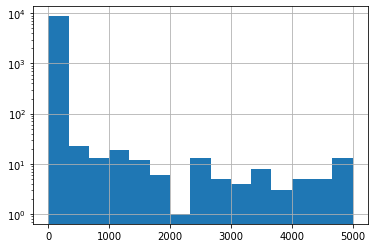

In [47]:
src_dest_results.sort_values(by=['Total'], ascending=False)['Total'].hist(bins=15, log=True)

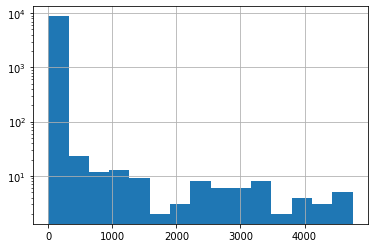

In [52]:
src_dest_results.sort_values(by=['Total'], ascending=False)['Once'].hist(bins=15, log=True)

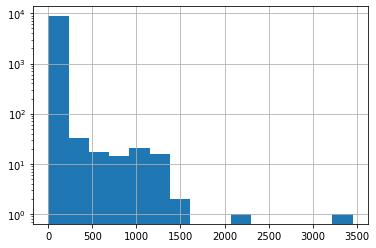

In [53]:
src_dest_results.sort_values(by=['Total'], ascending=False)['MoreThanOne'].hist(bins=15, log=True)